# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Цель исследования

Построение модели для определения стоимости автомобилей, сочетающей в себе оптимальное соотношение качества, скорости предсказания и времени обучения модели.

# План исследования

1. Загрузка данных для исследования из файла `autos.csv`.
2. О качестве данных информации нет, поэтому как приступать к исследованию проведем обзор данных.
3. Преобработка данных:
  * проверка данных на наличие пропусков и аномалий и их влияние на исследование 
  * исправление ошибок и заполнения пропусков, которые не приведут к искажению результатов исследования. 
  * анализ признаков на их информативность для построения модели.
4. Подготовка выборок данных для построения моделей.
5. Построение моделей машинного обучения:
   * `LinearRegression`
   * `Ridge`
   * `DecisionTree`
   * `LightGBM`, 
   * `CatBoosting` 
   
   Подбор лучших гиперпараметров для них.

6. Выбор лучшей модели по характеристикам, заданным заказчиком.

7. Тестирование выбранной модели и оценка результатов.

8. Оформление выводов по результатам исследования

**Описание данных**

Данные находятся в файле `/datasets/autos.csv`. Скачать датасет. 

**Признаки**

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

**Целевой признак**
* `Price` — цена (евро)

## Подготовка данных

На данном этапе мы сделаем следующее:
1. Загрузим данные.
2. Изучим данные. 
3. Заполним пропущенные значения и обработаем аномалии в столбцах. Удалим неинформативные признаки и сгенерируем новые при необходимости.

In [1]:
# установим модули
#!pip install phik
#!pip install lightgbm

In [2]:
#!pip install catboost==1.2

In [3]:
#!pip install category_encoders

In [4]:
# импорт библиотек для выполения проекта
import pandas as pd
import numpy as np
import phik
import category_encoders as ce

from datetime import datetime as dt
from scipy import stats

# графика
import seaborn as sns
import matplotlib.pyplot as plt

# импортируем функции и метрики из библиотеки sklearn
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

# метрики
from sklearn.metrics import mean_squared_error

# импортируем градиентные бустинги
from catboost import (CatBoostRegressor,
                      Pool)
from lightgbm import LGBMRegressor

# предупреждения
import warnings
warnings.filterwarnings('ignore')

In [5]:
# настроим отображение чисел и таблиц
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', 1000)
pd.set_option('max_colwidth', 1000)
pd.set_option('display.width', 500)
# выберем общее формление для графиков
sns.set(style="white", palette="Spectral")

In [6]:
try:
    data = pd.read_csv('./autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [7]:
# зафиксируем псевдослучайность random_state
RS = 2023
# количество фолдов для кросс-валидации
CV = 3
# сохраним исхоный размер данных
OLD_SHAPE = data.shape

In [8]:
def data_info(data_name):
    '''функция выводит информацию о данных'''
    
    print('\n\nДанные из выборки\n')
    display(data_name.head(5))
    display(data_name.tail(5))

    print(f'\n\nКоличество признаков: {data_name.shape[1]}, Количество наблюдений: {data_name.shape[0]}\n')
    
    print('\nИнформация о данных\n')
    info_list = []
    for item in data_name.columns:
        info_list.append({
            'Признак': item,
            'Тип данных': data_name.dtypes[item],
            'Уникальных значений': data_name[item].nunique(),
            '%Пропусков': data_name[item].isna().mean()*100
        })
    display(pd.DataFrame(info_list))
   

    print(f'\n\nКоличество полных дубликатов в данных: {data_name.duplicated().sum()}')

    print('\n\nОписательная статистика ')
    display(data_name.describe())

In [9]:
def best_model(model, params, features, target, cat_col_low, cat_col_higth, num_col):
    '''функция подбора гиперпараметров для заданной модели
    на входе: модель, параметры для подбора, фичи и таргет,
              категориальные признаки, числовые признаки,
              способ подбора параметров, по умолчанию GridSearchCV
    на выходе: подобранная модель и значение искомой метрики RSME'''
      
    preprocessor = ColumnTransformer(transformers=[
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse=True), cat_col_low),
    ('target', ce.TargetEncoder(min_samples_leaf=20, smoothing=10), cat_col_higth),
    ('scaler', StandardScaler(), num_col)])
    
    # собираем пайплайн    
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)])  
    
    # подбор гиперпараметров
    searcher = GridSearchCV(pipe,
                            param_grid=params,
                            scoring='neg_root_mean_squared_error',
                            cv=CV,
                            n_jobs=-1,
                            verbose=5)

    time_start = dt.now()
    search = searcher.fit(features, target)
    time_search = (dt.now() - time_start)
    
    # вычисляем время работы с лучшими параметрами
    pipe.set_params(**search.best_params_)
    
    time_start = dt.now()
    pipe.fit(features, target)
    time_fit = (dt.now() - time_start)
    
    time_start = dt.now()
    pipe.predict(features)
    time_predict = (dt.now() - time_start)
    
    list_best_params.append({'model': search.best_estimator_[-1],
                             'model_params': search.best_params_,
                             'RSME': abs(search.best_score_),
                             'time_search': time_search,
                             'time_fit': time_fit,
                             'time_predict': time_predict})

In [10]:
def del_info(data):
    ''' функция выводит информацию о проценте удаленных данных'''
    
    new_shape = data.shape
    percent_del = round(((1 - new_shape[0] / OLD_SHAPE[0]) *100), 1)
    print(f'\nНа текущий момент удалено {percent_del}% от исходного объема данных')

In [11]:
def add_mode_isna(data, column):
    ''' функция заполнения пропусков исходя из моды значений'''
    
    if data[column].notna().any():
        mode = stats.mode(data[column].dropna())[0][0]
        data[column].fillna(mode, inplace=True)
    return data

In [12]:
def print_result(list_for_print):
    '''выводим таблицу с данными'''
    # табличка с оптимизированными гиперпараметрами
    df_best_models = pd.DataFrame(list_for_print)
    display(df_best_models.head(10))

Приступим к осмотру данных

In [13]:
data_info(data)



Данные из выборки



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21




Количество признаков: 16, Количество наблюдений: 354369


Информация о данных



,Признак,Тип данных,Уникальных значений,%Пропусков
0,DateCrawled,object,271174,0.0000
1,Price,int64,3731,0.0000
2,VehicleType,object,8,10.5794
3,RegistrationYear,int64,151,0.0000
4,Gearbox,object,2,5.5967
5,Power,int64,712,0.0000
6,Model,object,250,5.5606
7,Kilometer,int64,13,0.0000
8,RegistrationMonth,int64,13,0.0000
9,FuelType,object,7,9.2827




Количество полных дубликатов в данных: 4


Описательная статистика 


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.0000,354369.0000,354369.0000,354369.0000,354369.0000,354369.0000,354369.0000
mean,4416.6568,2004.2344,110.0943,128211.1725,5.7146,0.0000,50508.6891
std,4514.1585,90.2280,189.8504,37905.3415,3.7264,0.0000,25783.0962
min,0.0000,1000.0000,0.0000,5000.0000,0.0000,0.0000,1067.0000
25%,1050.0000,1999.0000,69.0000,125000.0000,3.0000,0.0000,30165.0000
50%,2700.0000,2003.0000,105.0000,150000.0000,6.0000,0.0000,49413.0000
75%,6400.0000,2008.0000,143.0000,150000.0000,9.0000,0.0000,71083.0000
max,20000.0000,9999.0000,20000.0000,150000.0000,12.0000,0.0000,99998.0000


Обзор данных показывает:

1. К исследованию представлены более 350 тыс. наблюдений, содержащие 16 признаков
2. Среди признаков имеются числовые, категориальные и строковые данные
3. Имеются пропуски в данных: 
  * `VehicleType` - 10.6%
  * `Gearbox` - 5.6%
  * `Model` - 5.6%
  * `FuelType` - 9.3%
  * `Repaired` - 20.1%
4. Согласно описательной статистике имеются аномалии в данных:
  * Нулевые значение целевого признаков `Price`,`Power`	
  * `RegistrationYear` - транспорт зарегистрированный в 1000 и 9999гг.
5. В признаке `NumberOfPictures` все данные заполнены `0`, соответственно и ценность данного признака 0. 
6. Выявлено 4 полных дубликата. 

Учитывая вышеизженное:
 1. Следуя хорошему "змеиному" стилю, переименуем признаки используя:
    * нижний регистр
    * знак "__" для смыслового разделения
 2. Удалим полные дубликаты
 3. Рассмотрим остальные признаки подробнее, с целью принятия решений о судьбе пропусков и аномалий.
 4. Удалим признак `NumberOfPictures`, а также иные неинформативные признаки
 5. Проверим корреляцию признаков


In [14]:
# переименуем столбцы
list_name = []
for item in data.columns:
    new_name = ''.join([(' '+i if i.isupper() else i) for i in item]).strip().split()
    list_name.append('_'.join(new_name).lower())
data.columns = list_name

In [15]:
# список признаков к удалению
list_to_delete = ['number_of_pictures']

In [16]:
# удалим полные дубликаты
data.drop_duplicates(inplace=True)

Рассмотрим хронологические признаки (в данных признаках нет пропусков), оценим их информативность:
 * `date_crawled`
 * `date_created`	
 * `last_seen`
 
Преобразуем признаки к соответствующему типу с округлением до дня. 

In [17]:
list_date = ['date_crawled', 'date_created', 'last_seen']
for item in list_date:
    data[item] = pd.to_datetime(data[item], 
                                format='%Y-%m-%d', 
                                errors='ignore').dt.round('1D')

In [18]:
# немного статистики
data[list_date].describe()

,date_crawled,date_created,last_seen
count,354365,354365,354365
unique,34,109,34
top,2016-04-04 00:00:00,2016-04-03 00:00:00,2016-04-06 00:00:00
freq,13591,13718,75688
first,2016-03-06 00:00:00,2014-03-10 00:00:00,2016-03-06 00:00:00
last,2016-04-08 00:00:00,2016-04-07 00:00:00,2016-04-08 00:00:00


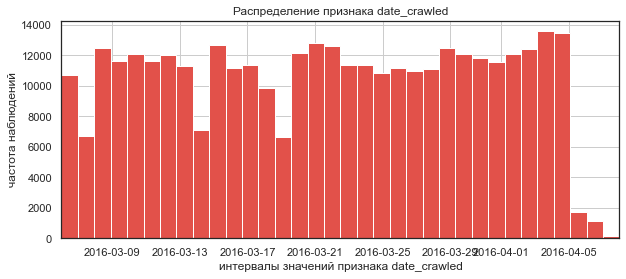

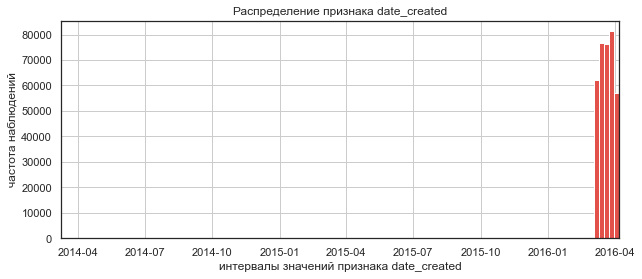

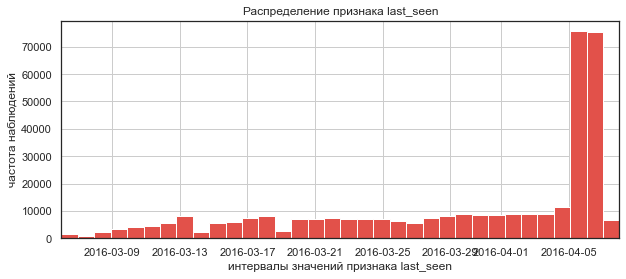

In [19]:
# посмотрим как распределены наблюдения по датам
for item in list_date:
    plt.figure(figsize=(10,4))
    data[item].hist(bins=data[item].nunique());
    plt.xlim(data[item].min(), data[item].max())
    plt.xlabel(f'интервалы значений признака {item}')
    plt.ylabel('частота наблюдений')
    plt.title(f'Распределение признака {item}')
    plt.show;

In [20]:
print(f'Количество анкет до ноября 2015:', data.query('date_created < "2015-11-01"').date_crawled.count())

Количество анкет до ноября 2015: 8


Из анализа хронологических признаков можно сделать предположение, что сервис "Не бит, не крашен" начал свою активную работу c конца 2015 года, именно с этого времени начинается активный прирост количества анкет и скачиваний.

Наблюдения до ноября 2015 года удалим из рассмотрения, считая из тестовыми.
Также удалим признаки `date_crawled`, `last_seen`, так как на ценообразование они явно никак не влияют, а только усложнят нашу модель.

In [21]:
# удалим тестовые анкеты
data = data.query('date_created > "2015-11-01"')

In [22]:
# дополним список признаков для удаления
list_to_delete = list_to_delete + ['date_crawled', 'last_seen']

Продолжим с хронологией:
 * `registration_year`
 * `registration_month`
 
В этих признаках также отсуствуют пропуски. Необходимо оценить адекватность данных.

Википедия нам говорит, что первые известные чертежи автомобиля (с пружинным приводом) принадлежат Леонардо да Винчи, однако ни действующего экземпляра, ни сведений о его существовании до наших дней не дошло... 

Только последнее десятилетие XIX века считается временем зарождения автомобильной промышленности.
Также из гистограммы и статистики видно, что имеются автомобили из будущего.

Проверим данные признака `registration_year` на адекватность:
 * проверим авто до 1890 года
 * записи с авто после 2016-04-08 (крайняя дата выгрузки анкеты) 

In [23]:
# фильтры по годам регистрации
filter_past_auto = data['registration_year'] < 1890
filter_future_auto = (data['registration_year'] > data['date_created'].max().year) | \
                   ((data['registration_year'] == data['date_created'].max().year) & \
                  (data['registration_month'] >= data['date_created'].max().month))

In [24]:
print(f'Количество авто, зарегистрированных до 1890 года: {data[filter_past_auto].shape[0]}')
print(f'Количество авто, зарегистрированных после {data.date_created.max().month} месяца {data.date_created.max().year} составляет: \
{data[filter_future_auto].shape[0]}')

Количество авто, зарегистрированных до 1890 года: 66
Количество авто, зарегистрированных после 4 месяца 2016 составляет: 19892


Удалим эти данные из рассмотрения.

In [25]:
data = data[~(filter_past_auto | filter_future_auto)]
del_info(data)


На текущий момент удалено 5.6% от исходного объема данных


Признак `registration_month` сделал свое дело, и далее можно его внести в список на удаление, так как объективно цена авто менее зависит от месяца его регистрации, чем от года.

In [26]:
# дополним список признаков для удаления
list_to_delete.append('registration_month')

**Ретро** автомобилями признаются автомобили старше 30 лет с момента их регистрации.

Учитывая этот факт, а так же то, что прогнозирование стоимости таких автомобилей - это уже вопрос экспертной деятельности, исключим из рассмотрения автомобили старше 30 лет. 

Мы располагаем данными системы с декабря 2015 по начало апреля 2016 года, оставим для рассмотрения автомобили зарегистрированные не позже 1985 года.

In [27]:
# фильтры по ретро
filter_retro_auto = data['registration_year'] <= 1985
print(f'Количество ретро автомобилей: {data[filter_retro_auto].shape[0]}')

Количество ретро автомобилей: 6138


In [28]:
data = data[~(filter_retro_auto)]
del_info(data)


На текущий момент удалено 7.4% от исходного объема данных


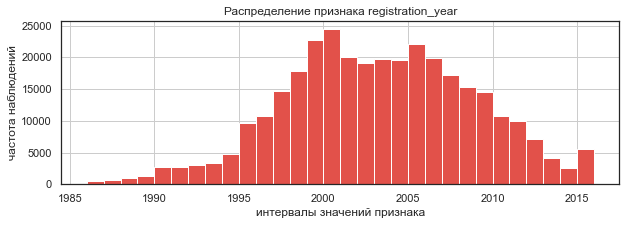

In [29]:
plt.figure(figsize=(10,3))
data['registration_year'].hist(bins=30);
plt.xlabel('интервалы значений признака')
plt.ylabel('частота наблюдений')
plt.title('Распределение признака registration_year')
plt.show;

Проведя обработку аномалий и выбросов, мы получили достаточно приличное распределение признака `registration_year`

Последний штрих с признаками хронологии -  создадим дополнительную колонку `age`, содержащую информацию о возрасте авто.
После чего, признаки `date_created` и `registration_year` внесем в список на удаление.

In [30]:
data['age'] = data['date_created'].dt.year - data['registration_year']

In [31]:
# дополним список признаков для удаления
list_to_delete = list_to_delete + ['registration_year', 'date_created']

С датами разобрались, идем дальше

In [32]:
# проверим значения признака
np.sort(data['postal_code'].unique())

array([ 1067,  1068,  1069, ..., 99994, 99996, 99998], dtype=int64)

Признак `postal_code` являются почтовыми индексами. По характеру данных можно предположить, что это все индексы Германии (если допустить, что в индексах до 10000 пропущен `0` в первой позиции).
Так как географически данные принадлежат одному государству, скорее всего корреляция между стоимостью автомобиля и почтовым индексом продавца вряд ли значительная. 

Поэтому исключим данный признак из рассмотрения.

In [33]:
# дополним список признаков для удаления
list_to_delete.append('postal_code')

In [34]:
# уалим неинформативные столбцы
data = data.drop(list_to_delete, axis=1)

Посмотрим на распределение числовых признаков:
 * `price`
 * `power`
 * `kilometer`

Рассмотрим целевой признак `price`. Оценим выбросы и аномалии.

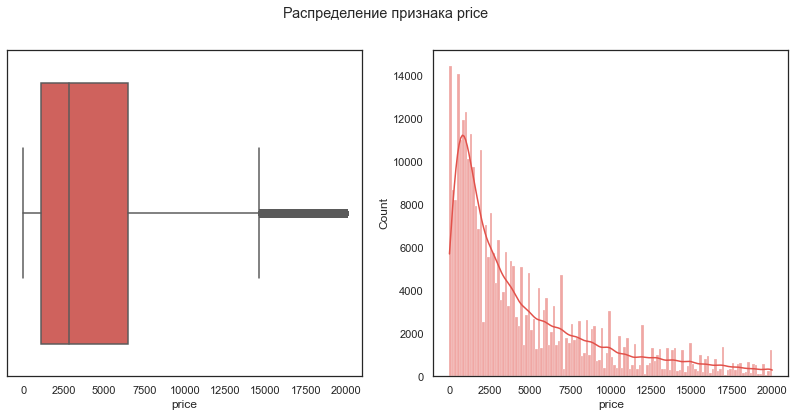

In [35]:
# построим распределение признака
fig, axs = plt.subplots(1, 2, figsize=(14,6));
fig. suptitle('Распределение признака price');
sns.boxplot(data=data, x='price', ax=axs[0]);
sns.histplot(data=data, x='price',ax=axs[1], kde=True);

По графикам видно, что имеется более 14 тыс.наблюдений с ценами близкими к нулю.

In [36]:
filter_chip = data['price'] <= 100
filter_expensive = data['price'] >= 17500

In [37]:
print('Количество авто дешевле 100 евро:', data[filter_chip].shape[0])
print('Количество авто дороже 17500 евро:', data[filter_expensive].shape[0])

Количество авто дешевле 100 евро: 12408
Количество авто дороже 17500 евро: 6669


In [38]:
# проверим, что там в дорогих авто
(data[filter_expensive].
 pivot_table(index='price', values='age', aggfunc={'mean', 'count'}).
 sort_values(by='count', ascending=False).head(10))

,count,mean
price,,
17500,535.0000,6.6804
18500,476.0000,5.9958
19500,415.0000,6.3711
17900,389.0000,6.3470
19900,359.0000,6.1727
18900,348.0000,6.1925
18000,273.0000,6.5018
19999,268.0000,5.9590
20000,248.0000,6.5202


In [39]:
# проверим, что там в авто до 100 евро
(data[filter_chip].
 pivot_table(index='price', values='age', aggfunc={'mean', 'count'}).
 sort_values(by='count', ascending=False).head(10))

,count,mean
price,,
0,9208.0000,15.9832
1,1010.0000,15.8614
100,959.0000,17.9645
50,298.0000,16.7953
80,135.0000,17.8963
99,100.0000,16.1800
10,78.0000,15.9231
70,65.0000,16.2308
60,54.0000,17.0370


Из анализа данных видно:
* в сегменте до 100 евро преобладают авто с пропусками в данных, а также авто cтарше 15 лет.
* в авто дороже 17 500 евро представлены достаточно свежие автомобили, не старше 7 лет.

Таким образом:
* удалим из рассмотрения условно "бесплатные" авто, так как заказчика вряд ли интересуют объявлени о благотворительности
* а вот дорогие авто все оставим, так как это наиболее интересный сегмент.


In [40]:
# фильтруем данные 
data = data[~filter_chip]
del_info(data)


На текущий момент удалено 10.9% от исходного объема данных


Рассмотрим признак `power`. 

* Признак `power` имеет очень неправдоподоые значений судя по описательной статистике.
* Наяндексив информацию о самых мощных автомобилях (с мощностью более 800 л.с.), имеющих стоимость нескольно млн. долларов/евро (явно не наш сегмент).
* Можно смело удалять их наших данных все авто с мощностью более 500 л.с. 

In [41]:
filter_power = data['power'] > 500
print('Количество авто, скрывающих более 500 л.с.:', data[filter_power].shape[0])

Количество авто, скрывающих более 500 л.с.: 368


In [42]:
data = data[~filter_power]
del_info(data)


На текущий момент удалено 11.0% от исходного объема данных


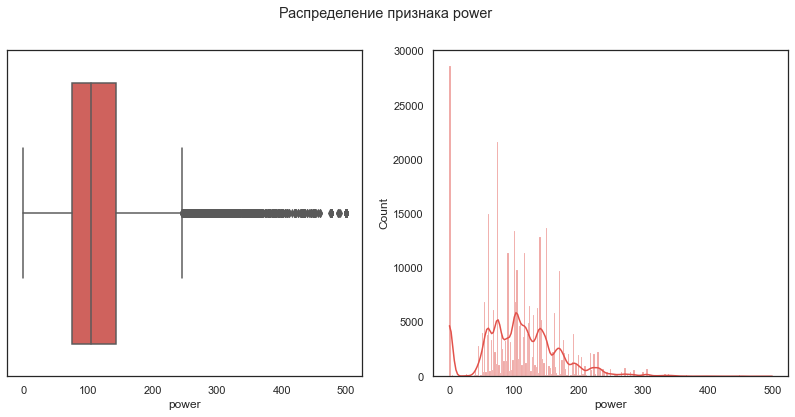

In [43]:
# построим распределение признака
fig, axs = plt.subplots(1, 2, figsize=(14,6))
fig. suptitle('Распределение признака power')
sns.boxplot(data=data, x='power', ax=axs[0]);
sns.histplot(data=data, x='power',ax=axs[1], kde=True)
plt.show()

In [44]:
print('Количество авто, скрывающих информацию о мощности:', data[data['power'] == 0].shape[0])

Количество авто, скрывающих информацию о мощности: 28648


Достаточно много записей с отсуствующей информацией о мощности автомобиля, но без нее, как и без возраста авто, предсказать цену на авто мы не сможем объективно.

In [45]:
data = data[data['power']!= 0]
del_info(data)


На текущий момент удалено 19.1% от исходного объема данных


Последний числовой признак `kilometr`

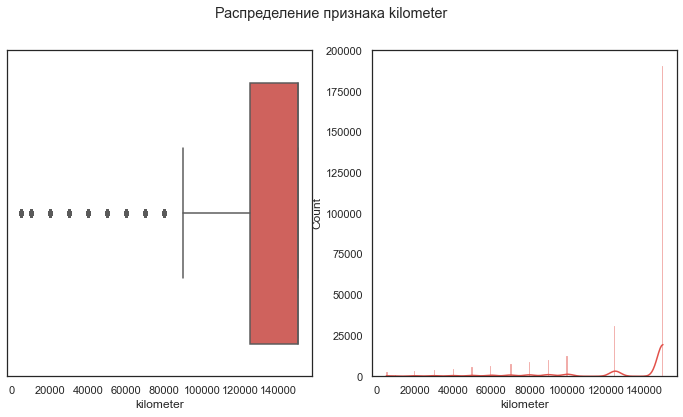

In [46]:
# построим распределение признака
fig, axs = plt.subplots(1, 2, figsize=(12,6))
fig. suptitle('Распределение признака kilometer')
sns.boxplot(data=data, x='kilometer', ax=axs[0]);
sns.histplot(data=data, x='kilometer',ax=axs[1], kde=True)
plt.show()

В данном признаке все выглядит объективно:
* бывают авто и без пробега
* и с пробегом 150 тыс.км., что характерно для авто старше 7 лет.

Сгенирируем дополнительный признак - пробег в год `km_per_year`

In [47]:
# сгенерируем признак, уберем бесконечность, преобразуем к целочисленному типу
data['km_per_year'] = round(data['kilometer'] / data['age'])
data.loc[data['km_per_year'] == np.inf, 'km_per_year'] = data['kilometer']
data['km_per_year'] = data['km_per_year'].astype('Int32')

Надо разобраться с **пропусками** в данных и оставшимися признаками:
* `vehicle_type`
* `gearbox`
* `model`
* `fuel_type`
* `brand`
* `repaired`

Посмотрим, что у нас осталось после зачистки аномальных значений.

In [48]:
print('% Пропусков в данных')
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient()

% Пропусков в данных


,0
price,0.000000
vehicle_type,2.000000
gearbox,2.000000
power,0.000000
model,3.000000
kilometer,0.000000
fuel_type,5.000000
brand,0.000000
repaired,14.000000
age,0.000000


Признак `repaired` имеет большую долю пропусков. 

Данный признак заполним значением `unk` - unknown, так как других логичных вариантов заполнения не имеется, при этом не ухудшая качество данных.

In [49]:
data['repaired'] = data['repaired'].fillna('unk')

Подозрительно одинаковый процент пропусков в признаках ...`vehicle_type`, `gearbox`, `model`
Возможно это технический сбой или ошибки. 

Отберем данные, с отсуствующей информацией в этих полях:

In [50]:
data[(data['vehicle_type'].isna() & data['model'].isna() & data['gearbox'].isna())].shape[0]

210

Удаляем эти максимально неинформативные строки:

In [51]:
data = data[~(data['vehicle_type'].isna() & data['model'].isna() & data['gearbox'].isna())]
del_info(data)


На текущий момент удалено 19.1% от исходного объема данных


In [52]:
print('Количество пропусков в данных')
pd.DataFrame(round(data.isna().sum(),)).style.background_gradient()

Количество пропусков в данных


,0
price,0
vehicle_type,6526
gearbox,4662
power,0
model,9694
kilometer,0
fuel_type,13154
brand,0
repaired,0
age,0


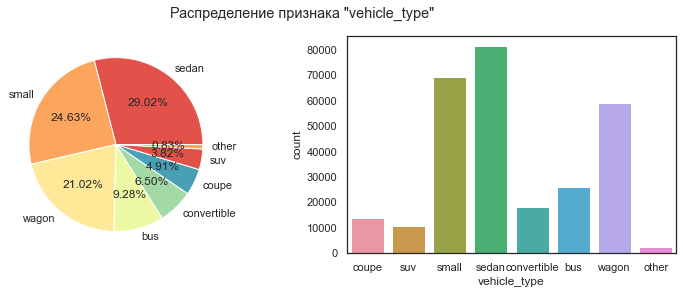

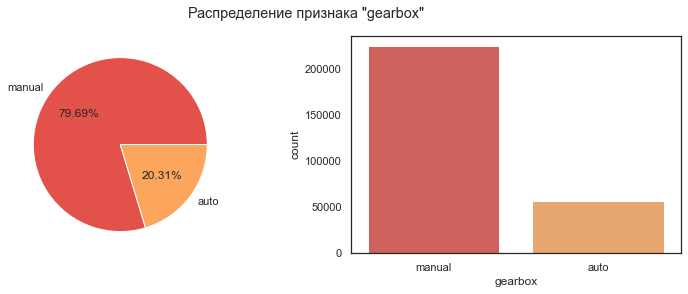

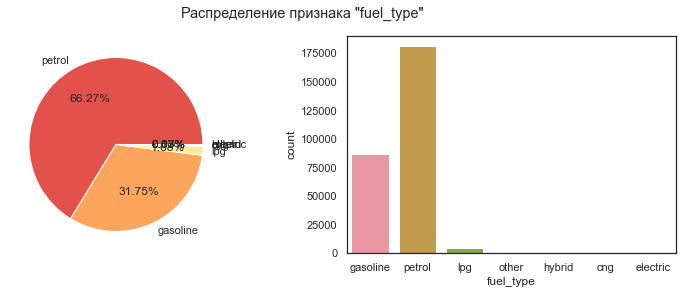

In [53]:
# построим распределение признака
for item in ['vehicle_type', 'gearbox', 'fuel_type']:
    df_item = pd.DataFrame(data[item].value_counts())
    fig, axs = plt.subplots(1, 2, figsize=(13,4))
    fig. suptitle(f'Распределение признака "{item}"')
    axs[0].pie(df_item[item], 
               labels= df_item.index, 
               autopct='%.2f%%')
    sns.countplot(data=data, x=item, ax=axs[1])
    plt.show()

Значения признаков `vehicle_type`, `gearbox`, `fuel_type` соответствуют действительным характеристикам для авто.


In [54]:
data_brand = (data.
              pivot_table(index='brand', values='model', aggfunc='count').
              reset_index().
              sort_values(by='model', ascending=False).
              head(10))

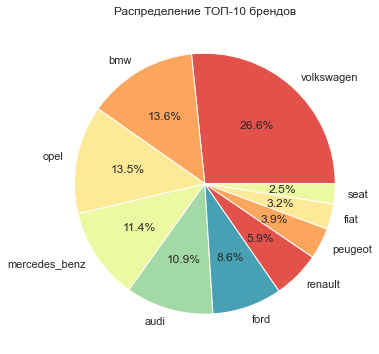

In [55]:
plt.figure(figsize=(12,6))
plt.pie(x=data_brand['model'], labels= data_brand['brand'], autopct='%.1f%%');
plt.title('Распределение ТОП-10 брендов');
plt.show()

По распределению данных можно сделать выводы:
* самый популярный автомобильный бренд Volkswagen
* самый распрастраненный вид топлива - бензин
* почти 80% автомоблей с автоматической КПП
* наиболее популярные типы авто - седан и "малолитражки".

Таким образом, мы имеет дело с объективными данными.
Осталось решить судьбу оставшихся пропусков.

Начнем с признака `model`.

Заполним в несколько этапов:
* наиболее частым значением в рамках бренда и мощности.
* в рамках бренда
* значением `unknown`

In [56]:
# заполними пропуски 1 этап
data_grouped = data.groupby(['brand', 'power'])
data = data_grouped.apply(add_mode_isna, 'model')

In [57]:
# заполними пропуски 2 этап
data_grouped = data.groupby(['brand'])
data = data_grouped.apply(add_mode_isna, 'model')

In [58]:
data['model'] = data['model'].fillna('unknown')

In [59]:
print('Количество пропусков в данных')
pd.DataFrame(round(data.isna().sum(),)).style.background_gradient()

Количество пропусков в данных


,0
price,0
vehicle_type,6526
gearbox,4662
power,0
model,0
kilometer,0
fuel_type,13154
brand,0
repaired,0
age,0


С остальными признаками поступим аналогично. Подбирать наиболее частое значение будем в рамках бренда и модели:

In [60]:
# завернем все в цикл, чтобы не копипастить код
for item in ['vehicle_type', 'gearbox', 'fuel_type']:
    data_grouped = data.groupby(['brand', 'model'])
    data = data_grouped.apply(add_mode_isna, item)

In [61]:
# проверка пропусков
print('Количество пропусков в данных')
pd.DataFrame(round(data.isna().sum(),)).style.background_gradient()

Количество пропусков в данных


,0
price,0
vehicle_type,0
gearbox,0
power,0
model,0
kilometer,0
fuel_type,0
brand,0
repaired,0
age,0


Проверим корреляцию признаков:

interval columns not set, guessing: ['price', 'power', 'kilometer', 'age', 'km_per_year']


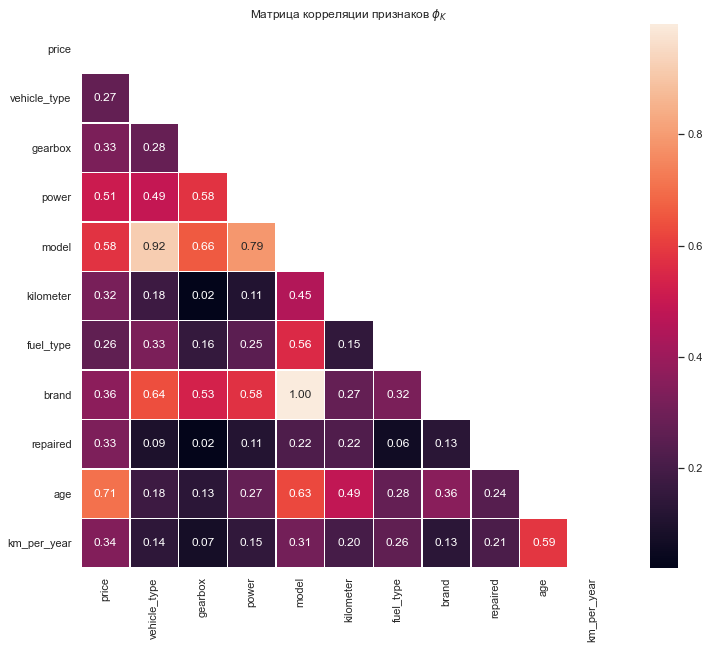

In [62]:
# визуализируем матрицу корреляции
phik_overview = data.phik_matrix()
mask = np.triu(np.ones_like(phik_overview, dtype=bool));
plt.figure(figsize=(12,10))
sns.heatmap(phik_overview, mask=mask,
          annot=True, 
          fmt=".2f", 
          linewidth=.5).set(title=r'Матрица корреляции признаков $\phi_K$');
plt.show();

**Вывод:**

на этапе произведены следующие шаги:
* загружены и исследованы данные
* осуществлено удаление аномалий и заполнение пропусков
* созданы дополнительные признаки и удалены неиформативные
* матрица корреляции свидетельсвует о наличии зависимости между признаками:
   * `brand` и `model`
   * `vehicle_type` и `model`
* целевой признак не имеет сильной корреляции ни с одним из признаков, более значительное влияние на цену, судя по матрице корреляции оказывают
   * `age` и `model`

## Обучение моделей

На этом этапе нам предстоит выполнить следующие шаги:

1. подготовка выборок для обучения и тестирования моделей
2. обучение разных моделей и подбор гиперпараметров:
   * `LinearRegression`
   * `Ridge`
   * `DecisionTree`
   * `LightGBM`, 
   * `CatBoosting` 
3. Анализ времени обучения, предсказания и качества моделей.
4. Выбор лучшей модели по притериям заказчика.

In [63]:
# подготовим фичи и таргеты
features = data.drop('price', axis=1)
target = data['price']

In [64]:
# разобьем выборку на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RS)
  
# проверим размеры выборок
print(f'Размер исходных данных: {data.shape[0]}')
print(f'Размер обучающей выборки: {features_train.shape[0]}')
print(f'Размер тестовой выборки: {features_test.shape[0]}')

Размер исходных данных: 286627
Размер обучающей выборки: 214970
Размер тестовой выборки: 71657


Для оценки качества моделей по заданию используем метрику `RSME`, она позволит оценить эффективность предсказания цены в тех же единицах, что и целевой показатель. При этом значение метрики должно быть менее 2500.

In [65]:
# определяем признаки
numerical_features = ['power', 'kilometer', 'age', 'km_per_year']
categorical_features_low = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
categorical_features_higth = ['brand', 'model']

In [66]:
# списко для агрегации результатов
list_best_params = []

Начнем по традиции с линейных моделей:
   * `LinearRegression`
   * `Ridge`

Так как наши модели не умеют работать с категориальными признаками и чувствительны к масштабу числовых признаков проведем подготовку данных встроенными средства Sklearn
   * кодирование категорий с помощью `OneHotEncoder`
   * масштабирование числовых с помощью `StandartScaler`
    
Подбор гиперпараметров осуществим с помощью `GridSearchCV`.

Чтобы избежать утечек данных все это завернем в `Pipeline`.

  **LinearRegression**

In [67]:
# подберем для каждой модели оптимальные  гиперпараметры
model_lr = LinearRegression()
# гиперпараметры для поиска
params_lr = {}

In [68]:
best_model(model_lr, params_lr, 
           features_train, target_train, 
           categorical_features_low, categorical_features_higth, numerical_features)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [69]:
print_result(list_best_params)

,model,model_params,RSME,time_search,time_fit,time_predict
0,LinearRegression(),{},2471.4599,0 days 00:00:02.547872,0 days 00:00:00.963831,0 days 00:00:00.389354


`RSME` на дефолтных параметрах модели в допустимых заданием границах, но это только начало.

**Ridge**

In [70]:
model_r = Ridge(random_state=RS)
# гиперпараметры для поиска
params_r = {'model__alpha': [0.0001, 0.01, 0.1, 1],
            'model__solver': ['svd', 'lsqr', 'sparse_cg', 'sag']}

In [71]:
best_model(model_r, params_r,
           features_train, target_train,
           categorical_features_low, categorical_features_higth, numerical_features)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [72]:
# табличка с оптимизированными гиперпараметрами
print_result(list_best_params)

,model,model_params,RSME,time_search,time_fit,time_predict
0,LinearRegression(),{},2471.4599,0 days 00:00:02.547872,0 days 00:00:00.963831,0 days 00:00:00.389354
1,"Ridge(alpha=1, random_state=2023, solver='svd')","{'model__alpha': 1, 'model__solver': 'svd'}",2471.4585,0 days 00:01:38.086531,0 days 00:00:01.033942,0 days 00:00:00.393359


Подбор гиперпараметров не улучших значение метрики на модели `Ridge` по сравнению с `LinearRegression` с параметрами по умолчанию.

**DecisionTreeRegressor**

Проверим как себя поведет базовая "деревянная" модель

In [73]:
model_dt = DecisionTreeRegressor(random_state=RS)
# гиперпараметры для поиска
params_dt = {'model__max_depth': [None] + [i for i in range(6, 8)]}

In [74]:
best_model(model_dt, params_dt, 
           features_train, target_train, 
           categorical_features_low, categorical_features_higth, numerical_features)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [75]:
# табличка с оптимизированными гиперпараметрами
print_result(list_best_params)

,model,model_params,RSME,time_search,time_fit,time_predict
0,LinearRegression(),{},2471.4599,0 days 00:00:02.547872,0 days 00:00:00.963831,0 days 00:00:00.389354
1,"Ridge(alpha=1, random_state=2023, solver='svd')","{'model__alpha': 1, 'model__solver': 'svd'}",2471.4585,0 days 00:01:38.086531,0 days 00:00:01.033942,0 days 00:00:00.393359
2,DecisionTreeRegressor(random_state=2023),{'model__max_depth': None},1844.3033,0 days 00:00:05.441952,0 days 00:00:02.136947,0 days 00:00:00.469427


Результат уже получше. Посмотрим, что нам выдадут бустинги:
   * `LGBMRegressor`
   * `CatBoostRegressor`

**LGBMRegressor**

Для минимизации времени подбора параметров, ограничимся наиболее значимыми из них:

In [76]:
model_lgbm = LGBMRegressor(random_state=RS)
params_lgbm = {
    'model__n_estimators': [1000, 2000, 2500],
    'model__learning_rate': [0.1, 0.2]
}

In [77]:
best_model(model_lgbm, params_lgbm, 
           features_train, target_train, 
           categorical_features_low, categorical_features_higth, numerical_features)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [78]:
# табличка с оптимизированными гиперпараметрами
print_result(list_best_params)

,model,model_params,RSME,time_search,time_fit,time_predict
0,LinearRegression(),{},2471.4599,0 days 00:00:02.547872,0 days 00:00:00.963831,0 days 00:00:00.389354
1,"Ridge(alpha=1, random_state=2023, solver='svd')","{'model__alpha': 1, 'model__solver': 'svd'}",2471.4585,0 days 00:01:38.086531,0 days 00:00:01.033942,0 days 00:00:00.393359
2,DecisionTreeRegressor(random_state=2023),{'model__max_depth': None},1844.3033,0 days 00:00:05.441952,0 days 00:00:02.136947,0 days 00:00:00.469427
3,"LGBMRegressor(n_estimators=2500, random_state=2023)","{'model__learning_rate': 0.1, 'model__n_estimators': 2500}",1454.2807,0 days 00:01:23.601148,0 days 00:00:07.556883,0 days 00:00:02.760515


Целевая метрика значительно улучшилась, а время работы при этом не значительно больше, чем обычного дерева.

**CatBoostRegressor**

На десерт!

С этим бустингом не получится использовать `GridSearchSV` от `sklearn`. Но есть отличная новость, так как имеется родной метод в этой же библиотеке, да еще и графики красивые строит!

<span class="mark"><span class="mark">Warning</span>

"Do not use one-hot encoding during preprocessing. This affects both the training speed and the resulting quality".</span>

Последуем предупреждению и не будем делать OHE. Подадим, как везде рекомендую в модель наши преобработанные данные.

In [90]:
# создадим модель
model_cb = CatBoostRegressor(random_state=RS, 
                             loss_function='RMSE',
                             verbose=False,
                             thread_count=-1)
pool_train = Pool(features_train, target_train, 
                  cat_features=(categorical_features_low + categorical_features_higth))

В ходе работы над проектом, перебирались неоднократно параметры, ниже для поиска оставлены максимально приближенные к оптимальным.

С помощью встроенных методом поиска гиперпараметров, а также их визуалиацией, был сделан вывод, что приглубине на итоговое зачение `RSME` лучше влияет увеличение числа итераций, чем углубление дерева.

Визаулизация явно показывает, что приувеличении максимальной глубины дерева алгоритм переобучается, и разрыв между обучающей выборкой и тестовой растет.

   **график RSME (на трейне и тесте)**


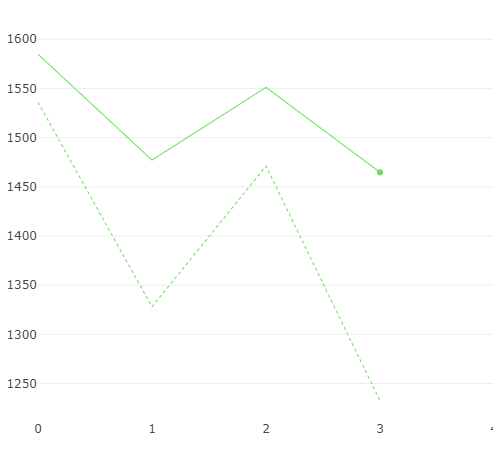


In [91]:
# # # гиперпараметры для поиска
# params_cb = {'iterations':[500, 1000],
#              'learning_rate': [0.1],
#              'depth': [8, 10],
#              'l2_leaf_reg': [9]
#             }
# # гиперпараметры для поиска - итоговые, чтобы ускорить
params_cb = {'iterations':[1000],
             'learning_rate': [0.1],
             'depth': [10],
             'l2_leaf_reg': [9]
            }

In [92]:
# # подброб гиперпараметров
time_start = dt.now()
search_cb = model_cb.randomized_search(params_cb,
                                       pool_train,
                                       plot=True)
time_search = dt.now() - time_start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 1466.359326
bestIteration = 999

0:	loss: 1466.3593263	best: 1466.3593263 (0)	total: 2m 56s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 1485.998965
bestIteration = 997

Training on fold [1/3]

bestTest = 1453.44095
bestIteration = 996

Training on fold [2/3]

bestTest = 1467.244098
bestIteration = 996



In [93]:
pd.DataFrame(search_cb['cv_results'])

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,6146.7504,18.9889,6145.1988,5.7916
1,1,5631.7704,16.5493,5628.6463,7.0948
2,2,5172.8077,15.3519,5169.2754,7.3356
3,3,4765.1287,13.7135,4761.1408,7.3634
4,4,4396.7157,10.9991,4391.5861,9.3173
...,...,...,...,...,...
995,995,1468.9898,16.3487,1281.6259,6.0431
996,996,1468.9226,16.3854,1281.4256,6.0240
997,997,1468.9117,16.3191,1281.3134,6.1346
998,998,1468.9249,16.3203,1281.1726,6.1380


In [95]:
# вычисляем время работы с лучшими параметрами
time_start = dt.now()
model_cb.fit(features_train, target_train, 
             cat_features=(categorical_features_low + categorical_features_higth))
time_fit = (dt.now() - time_start)

time_start = dt.now()
model_cb.predict(features_train)
time_predict = (dt.now() - time_start)

In [96]:
list_best_params.append({'model': 'CatBoostRegressor()',
                         'model_params': model_cb.get_params(),
                         'RSME': model_cb.best_score_.get('learn').get('RMSE'),
                         'time_search': time_search,
                         'time_fit': time_fit,
                         'time_predict': time_predict})

In [97]:
# табличка с оптимизированными гиперпараметрами
print_result(list_best_params)

,model,model_params,RSME,time_search,time_fit,time_predict
0,LinearRegression(),{},2471.4599,0 days 00:00:02.547872,0 days 00:00:00.963831,0 days 00:00:00.389354
1,"Ridge(alpha=1, random_state=2023, solver='svd')","{'model__alpha': 1, 'model__solver': 'svd'}",2471.4585,0 days 00:01:38.086531,0 days 00:00:01.033942,0 days 00:00:00.393359
2,DecisionTreeRegressor(random_state=2023),{'model__max_depth': None},1844.3033,0 days 00:00:05.441952,0 days 00:00:02.136947,0 days 00:00:00.469427
3,"LGBMRegressor(n_estimators=2500, random_state=2023)","{'model__learning_rate': 0.1, 'model__n_estimators': 2500}",1454.2807,0 days 00:01:23.601148,0 days 00:00:07.556883,0 days 00:00:02.760515
4,CatBoostRegressor(),"{'loss_function': 'RMSE', 'verbose': False, 'random_state': 2023, 'depth': 10, 'l2_leaf_reg': 9, 'iterations': 1000, 'learning_rate': 0.1}",1315.0692,0 days 00:14:54.702305,0 days 00:03:24.216021,0 days 00:00:01.108999


Как видно из приведенного свода данных, 
* наилучшие результаты на обучающей выборке показала модели `CatBoostRegressor` и  `LGBMRegressor`
* но при этом если рассматривать данные, которые мы получили в результате подбора гиперпараметров `CatBoostRegressor`, то видна существенная разница метрики на обучающей и валиационной выборках.
* Время подбора параметров `CatBoost` - почти 17 минут, что существенно (((
* По времени обучения модели лидирует `LGBMRegressor`, а вот по времени предсказания - уступает `CatBoostRegressor` 

## Анализ моделей

Поэтому проверим обе модели на тестовой выборке.

  * `LGBMRegressor`
  * `CatBoostRegressor`
  
так как они дают схожие результаты, но при этом время обучения больше у `CatBoostRegressor`, но меньше время предсказания.



`CatBoostRegressor`

In [98]:
time_start = dt.now()
predictions = model_cb.predict(features_test, thread_count=-1)
time_predict = dt.now() - time_start

rsme_cb = mean_squared_error(target_test, predictions, squared=False)

print(f'RSME модели CatboostRegressor: {rsme_cb:.2f}')
print(f'Время предсказания на тестовой выборке модели CatboostRegressor: {time_predict}')

RSME модели CatboostRegressor: 1464.75
Время предсказания на тестовой выборке модели CatboostRegressor: 0:00:00.369335


* Метрика на тесте вышла ровно такой, которая и была рассчитана на этапе подбора гиперпараметров. Это очень радует! 

* Следовательно, можно ориентироваться смело на показатели, полученные при кросс-валидации / подборе параметров.

* Время предсказания 37 милисекунд! Отлично!

`LGBMRegressor`

In [99]:
model_lgbm = LGBMRegressor(learning_rate=0.1, n_estimators=2500, random_state=RS)
preprocessor = ColumnTransformer(transformers=[
    ('OHE', OneHotEncoder(handle_unknown='ignore', sparse=True), 
     categorical_features_low),
    ('target', ce.TargetEncoder(min_samples_leaf=20, smoothing=10), 
     categorical_features_higth),
    ('scaler', StandardScaler(), numerical_features)])

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model_lgbm)
])  

In [100]:
time_start = dt.now()
pipe.fit(features_train, target_train)
time_fit = (dt.now() - time_start)

time_start = dt.now()
predictions = pipe.predict(features_test)
time_predict = (dt.now() - time_start)

In [101]:
rsme_lgbm = mean_squared_error(target_test, predictions, squared=False)

print(f'RSME модели LGBMRegressor: {rsme_lgbm:.2f}')
print(f'Время предсказания на тестовой выборке модели LGBMRegressor: {time_predict}')

RSME модели LGBMRegressor: 1431.54
Время предсказания на тестовой выборке модели LGBMRegressor: 0:00:00.991904


А вот эта модель результат показала даже лучше, чем ожидалось. И время почти секунда, правда больше чем `CatBoostRegressor`. Но тем не менее это ПОЧТИ секунда, но меньше.

## **Выводы:**

В ходе реализации проекта были выполнены следующие этапы:

1. подготовка данных

* загружены и изучены данные
* проанализированы признаки, неинформативные признаки удалены из выборки
* проведена преобработка данных
* проведен анализ данных, аномальные данные исключены из рассмотрения
* сгенерированы дополнительные признаки

2. Построение ML и подбор гиперпараметров

* данные разбиты на обучающую и тестовую выборки
* построены модели, проведена оценка метрики методом кросс-валидации
  - `LinearRegression`
  - `Ridge`
  - `DecisionTree`
  - `LightGBM`
  - `CatBoosting`
* проведена оценка времени обучения, времени предсказания
* подобраны лучшие гиперпараметры
* выбрана лучшая модель по показателям метрики и критериям заказчика

3. Проверено качество лучших модели на тестовой выборке.

В итоге все-таки победила `LightGBM`, у нее оказался лучший `RSME`:
* Итоговый показатель `RSME` составил - 1431.54
* Время предсказания - почти секунда.

Дополнительно модель проверена на адекватность c помощью DummyRegressor() - он молниеносный, но бестолковый в нашем случае.